# Model Remediation

In [74]:
import datetime                                               # for timestamp 
import h2o                                                    # base h2o package for python
from h2o.estimators import *                                  # h2o models
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch                # grid search class and syntax for h2o models
from h2o.estimators.deeplearning import H2ODeepLearningEstimator # h2o deep learning model
from interpret import show                                    # basic visualizations from interpret package
from interpret.data import ClassHistogram                     # histogram
from interpret.glassbox import *                              # interpret glassboxx models
from interpret.perf import ROC                                # ROC measure for ebm
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import seaborn as sns                                         # slightly better plotting  
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python
from rmltk import explain, evaluate, model                    # simple module for training, explaining, and eval
import operator                                               # to sort dictionaries
from imblearn.over_sampling import RandomOverSampler          #Handle class imbalance
from imblearn.under_sampling import RandomUnderSampler        #Handle class imbalance
from imblearn.over_sampling import SMOTE                      #Handle class imbalance
from collections import Counter           
import shap                                                   # for visualizing Shapley values
from sklearn.metrics import accuracy_score, f1_score          # for selecting model cutoffs
import random
# set numpy random seed for better reproducibility
SEED = 12345 

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 53 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_adelhassen_qluaxv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.197 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


### Define Functions

#### Utility function for confusion matrices for all demographic groups

In [13]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        :param verbose: Whether to print confusion matrix titles, default True. 
        :return: Confusion matrix as pandas dataframe. 
        
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True) 

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19
    
    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))
    
    return cm_frame

#### Utility function to calculate AIR

In [14]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and 
        reference group acceptance rates: protected_prop/reference_prop. 
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices. 
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True. 
        :return: AIR.
        
    """

    eps = 1e-20 # numeric stability and divide by 0 protection
    
    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    return ((protected_prop + eps)/(reference_prop + eps))

#### Utility function for prob cutoff of F1

In [52]:
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None): 
    
    """ Utility function for finding max. F1. 
        Coupled to get_confusion_matrix() and air(). 
        Assumes 1 is the marker for class membership.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.
    
    """
    
    do_air = all(v is not None for v in [air_reference, air_protected])
    
    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])
    
    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)
    
    # find f1 at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR  
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=False)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=False)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=False)
            row_dict['air'] = air_
            
        f1_frame = f1_frame.append(row_dict, ignore_index=True)
            
    del temp_df
        
    return f1_frame  

#### Utility function for random EBM grid search

In [72]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None,
             air_reference=None, air_protected=None, air_cut=None):
    
    """ Performs a random grid search over n_models and gs_params.
        Optionally considers random feature sets and AIR.
        Coupled to get_confusion_matrix() and air(). 

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.  
    :param air_cut: Cutoff for AIR calculation, optional.
    :return: Tuple: (Best EBM model, Pandas DataFrame of models to select from)

    """
    
    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air: 
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    ebm_grid_frame = pd.DataFrame(columns=columns)
    
    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        
        # conditionally select random features 
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = ebm.fit(train[features], train[y_name]) 

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # compose values to add to ebm_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR  
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=False)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=False)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=False)
            row_dict['air'] = air_
            del valid_phat

        # append run to ebm_grid_frame
        ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_ebm = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del row_dict
        del ebm
            
    return best_ebm, ebm_grid_frame

#### Start global timer

In [2]:
global_tic = time.time()

#### Import data

In [3]:
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

#### Assign predictors and response

In [4]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

### Fit EBM Model

#### Split data into training and validation sets

In [180]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


#### Fit EBM with random grid search

In [181]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm, ebm_grid_frame = ebm_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=10, 
                                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8217.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

#### Basic AUC assessment

In [182]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8247.


#### Score validation data with model

In [183]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat']) 
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.171009
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.323614
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.023242
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.015636
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004191


### EBM Discrimination Testing

#### Find optimal cutoff based on F1

In [184]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.233663  0.383966
2    0.02  0.262216  0.478756
3    0.03  0.280327  0.530061
4    0.04  0.295720  0.569200
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3662 achieved at cutoff: 0.17 with accuracy: 0.7793.


#### Confusion matrcies for different demographic groups

In [185]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()
    

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       493       993
predicted: 0       171      1535

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        99       206
predicted: 0        49      2896

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      2091      6723
predicted: 0      1074     24637

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1      1111      3436
predicted: 0       553     10732

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       897      2397
predicted: 0       343      6395



AIR is calculated by % accepted of protected group / % accepted of reference group. To compare race groups, we will use White people as the reference group. For gender comparisons, we will use males as the reference group. Here, take the sum of predicted 0 and divide by the total to get the % accepted.



#### AIR for Black people

In [186]:
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))


White proportion accepted: 0.745
Black proportion accepted: 0.534
Adverse impact ratio for Black people vs. White people: 0.718


Black proportion accepted is extremely low compared to other groups. This makes it a good candidate for further analysis and remediating discrimination in this model.

#### AIR for Asian people

In [187]:
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian'))


White proportion accepted: 0.745
Asian proportion accepted: 0.906
Adverse impact ratio for Asian people vs. White people: 1.217


#### AIR for Females

In [188]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))


Male proportion accepted: 0.713
Female proportion accepted: 0.672
Adverse impact ratio for Females vs. Males: 0.942


The AIR is above 0.8 for the Asian group and the females.

### Remediate discrimination

#### Easy approach: find cutoff with higher AIR for Black vs White people

In [189]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

,cut,f1,acc,air
22,0.22,0.353556,0.832921,0.823237
23,0.23,0.347684,0.841822,0.844324
24,0.24,0.339292,0.850889,0.868422
25,0.25,0.329670,0.859187,0.878782
26,0.26,0.315778,0.865717,0.887457


Cutoffs from 0.22 to 0.26 provide estimations with an AIR between Black and White people of above 0.8.

#### Other groups are not negatively affected by the change in cutoff

In [190]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=0.22, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.125
Adverse impact ratio for Black people vs. White people: 0.823
Adverse impact ratio for Females vs. Males: 0.967


The other protected groups are still above 0.8 with the new cutoff.

#### Model selection considering quality and fairness

We will use a cutoff of 0.17 to fit a new EBM model while considering quality as well as fairness.

In [284]:
# start local timer
ebm2_tic = time.time()

# new grid search that also considers AIR and fairness
best_ebm2, ebm_grid_frame = ebm_grid(train, best_ebm_phat, x_names, y_name, gs_params=gs_params, n_models=500, 
                                     early_stopping_rounds=100, seed=SEED, air_reference='white', air_protected='black', 
                                     air_cut=0.17)

# end local timer
ebm2_toc = time.time() - ebm2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/500: 0.8202.
---------- ----------
Grid search run 2/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 26/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ----------
Grid search run 27/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ----------
Grid search run 28/500:
Training with parame

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 51/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 52/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 53/500:
Training with parameters:

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}
---------- ----------
Grid search run 75/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 1}
---------- ----------
Grid search run 76/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
---------- ----------
Grid search run 77/500:
Training with paramet

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 100/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 101/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}
---------- ----------
Grid search run 102/500:
Training with param

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}
---------- ----------
Grid search run 125/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}
---------- ----------
Grid search run 126/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 127/500:
Training with parame

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}
---------- ----------
Grid search run 150/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}
---------- ----------
Grid search run 151/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}
---------- ----------
Grid search run 152/500:
Training with par

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 175/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 176/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 177/500:
Training with parame

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}
---------- ----------
Grid search run 200/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 201/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ----------
Grid search run 202/500:
Training with paramet

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 225/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 1}
---------- ----------
Grid search run 226/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 227/500:
Training with parame

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 1}
---------- ----------
Grid search run 250/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}
---------- ----------
Grid search run 251/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}
---------- ----------
Grid search run 252/500:
Training with paramete

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 275/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 1}
---------- ----------
Grid search run 276/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 277/500:
Training with p

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}
---------- ----------
Grid search run 300/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 301/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 302/500:
Training with paramet

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ----------
Grid search run 325/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 3}
---------- ----------
Grid search run 326/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 15, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 1}
---------- ----------
Grid search run 327/500:
Training with para

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 350/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}
---------- ----------
Grid search run 351/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 352/500:
Training with paramete

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}
---------- ----------
Grid search run 375/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 376/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 1}
---------- ----------
Grid search run 377/500:
Training with paramete

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 400/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 401/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}
---------- ----------
Grid search run 402/500:
Training with para

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 425/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 426/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 427/500:
Training with parame

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 1}
---------- ----------
Grid search run 450/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 451/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 452/500:
Training with parame

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 475/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 3}
---------- ----------
Grid search run 476/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}
---------- ----------
Grid search run 477/500:
Training with parameters

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 10, 'max_leaves': 3}
---------- ----------
Grid search run 500/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 3}
---------- ----------
EBM training completed in 41989.42 s.


In [285]:
ebm_grid_frame

,max_bins,max_interaction_bins,interactions,outer_bags,inner_bags,learning_rate,validation_size,min_samples_leaf,max_leaves,features,auc,air,early_stopping_rounds,n_jobs,random_state
0,512,16,5,4,0,0.050,0.25,1,3,"[loan_amount_std, property_value_std, conforming, no_intro_rate_pe...",0.820197,0.723869,100.0,4.0,12345.0
1,128,32,5,8,0,0.001,0.25,2,5,"[term_360, income_std, property_value_std, loan_amount_std, no_int...",0.800310,0.712422,100.0,4.0,12345.0
2,512,16,5,4,0,0.001,0.50,1,3,"[intro_rate_period_std, conforming, income_std, debt_to_income_rat...",0.770647,0.826767,100.0,4.0,12345.0
3,128,64,5,4,4,0.050,0.50,1,5,"[property_value_std, debt_to_income_ratio_missing, loan_amount_std...",0.780946,0.650278,100.0,4.0,12345.0
4,512,64,15,4,0,0.050,0.10,10,3,"[conforming, debt_to_income_ratio_missing, loan_to_value_ratio_std]",0.760012,0.584300,100.0,4.0,12345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,256,32,5,8,4,0.010,0.50,10,1,"[conforming, loan_amount_std, term_360, intro_rate_period_std, deb...",0.698525,0.993971,100.0,4.0,12345.0
496,512,32,15,8,4,0.001,0.10,10,3,"[conforming, loan_amount_std, debt_to_income_ratio_missing, proper...",0.791444,0.692527,100.0,4.0,12345.0
497,256,16,15,12,0,0.050,0.25,5,3,"[income_std, property_value_std, debt_to_income_ratio_std, no_intr...",0.791107,0.749655,100.0,4.0,12345.0
498,128,64,10,12,0,0.001,0.50,10,3,"[debt_to_income_ratio_std, no_intro_rate_period_std]",0.626315,0.897869,100.0,4.0,12345.0


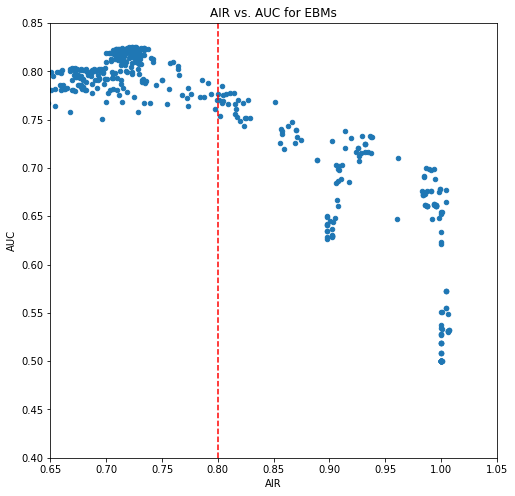

In [286]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ebm_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for EBMs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.65, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

In [287]:
# extract new params dict from ebm_grid_frame
rem_params = ebm_grid_frame.loc[ebm_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict 
rem_x_names = rem_params['features']
del rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name]) 
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)


Best AUC: 0.7850 above 0.8 AIR (0.8034).
Remediated EBM retrained with AUC: 0.7850.


In [288]:
# create a frame with remediated EBM predictions
best_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat']) 
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_ebm_phat2, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.156
Adverse impact ratio for Black people vs. White people: 0.803
Adverse impact ratio for Females vs. Males: 0.955


In [275]:
# start local timer
ebm2_tic = time.time()

# new grid search that also considers AIR and fairness
best_ebm2, ebm_grid_frame = ebm_grid(train, best_ebm_phat, x_names, y_name, gs_params=gs_params, n_models=100, 
                                     early_stopping_rounds=100, seed=SEED, air_reference='white', air_protected='black', 
                                     air_cut=0.17)

# end local timer
ebm2_toc = time.time() - ebm2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/100: 0.8150.
---------- ----------
Grid search run 2/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
Grid search new best score discovered at iteration 2/100: 0.8174.
---------- ----------
Grid search run 3/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'lear

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 26/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ----------
Grid search run 27/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ----------
Grid search run 28/100:
Training with parame

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 50/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 51/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 52/100:
Training with parameters:

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}
---------- ----------
Grid search run 75/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 1}
---------- ----------
Grid search run 76/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
---------- ----------
Grid search run 77/100:
Training with paramet

Grid search run 99/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 100/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
EBM training completed in 7237.05 s.


#### Grid search result as a table

In [278]:
ebm_grid_frame

,max_bins,max_interaction_bins,interactions,outer_bags,inner_bags,learning_rate,validation_size,min_samples_leaf,max_leaves,features,auc,air,early_stopping_rounds,n_jobs,random_state
0,512,16,5,4,0,0.050,0.25,1,3,"[debt_to_income_ratio_missing, property_value_std, conforming, inc...",0.814965,0.734289,100.0,4.0,12345.0
1,128,32,5,8,0,0.001,0.25,2,5,"[no_intro_rate_period_std, debt_to_income_ratio_std, intro_rate_pe...",0.817386,0.722409,100.0,4.0,12345.0
2,512,16,5,4,0,0.001,0.50,1,3,"[property_value_std, loan_to_value_ratio_std, no_intro_rate_period...",0.816493,0.735255,100.0,4.0,12345.0
3,128,64,5,4,4,0.050,0.50,1,5,"[property_value_std, conforming, debt_to_income_ratio_missing, ter...",0.795184,0.665909,100.0,4.0,12345.0
4,512,64,15,4,0,0.050,0.10,10,3,"[no_intro_rate_period_std, loan_to_value_ratio_std, property_value...",0.820062,0.717946,100.0,4.0,12345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,128,64,5,4,4,0.010,0.50,1,3,"[no_intro_rate_period_std, loan_to_value_ratio_std, term_360, debt...",0.795919,0.677882,100.0,4.0,12345.0
96,512,16,15,12,4,0.010,0.10,5,5,"[loan_to_value_ratio_std, property_value_std, debt_to_income_ratio...",0.797922,0.680223,100.0,4.0,12345.0
97,128,32,5,12,4,0.050,0.50,2,5,"[loan_to_value_ratio_std, debt_to_income_ratio_missing, property_v...",0.819318,0.719229,100.0,4.0,12345.0
98,256,64,15,8,4,0.001,0.25,5,5,"[debt_to_income_ratio_std, debt_to_income_ratio_missing, loan_amou...",0.822134,0.722539,100.0,4.0,12345.0


#### Grid search result as a plot

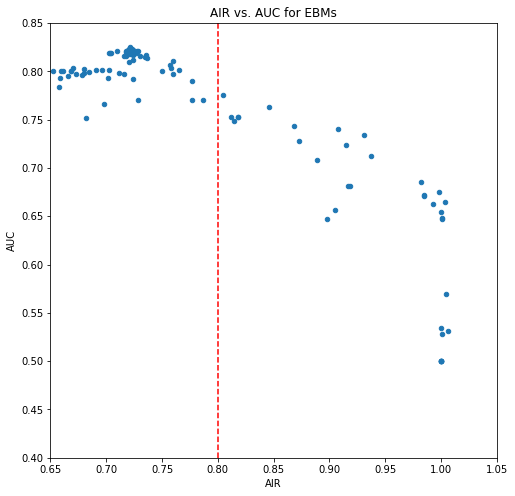

In [279]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ebm_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for EBMs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.65, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

#### Retrain most accurate model above 0.8 AIR

In [280]:
# extract new params dict from ebm_grid_frame
rem_params = ebm_grid_frame.loc[ebm_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict 
rem_x_names = rem_params['features']
del rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name]) 
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)


Best AUC: 0.7754 above 0.8 AIR (0.8045).
Remediated EBM retrained with AUC: 0.7754.


#### Check that other groups are not negatively impacted

In [281]:
# create a frame with remediated EBM predictions
best_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat']) 
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_ebm_phat2, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.156
Adverse impact ratio for Black people vs. White people: 0.805
Adverse impact ratio for Females vs. Males: 0.960


With a cutoff of 0.17, the model is less discriminatory with a loss in AUC.

### Sampling Approach - Fix the Data

#### Check how our training data breaks down by race

In [196]:
race_names = ['black', 'asian', 'white']

for name in race_names:
    length = len(train.loc[train[name] == 1])
    print('There are %.0f' % (length),name, 'people in our training data')
    

There are 7660 black people in our training data
There are 7591 asian people in our training data
There are 80606 white people in our training data


We have more than 10 times more White people than either Black people or White people. This training data is not representative of our general population which leads to discriminatory issues. When one group is much more represented than others, the model could potentially learn more about the well represented group while neglecting the other groups. We want to fairly represent each group so we will take a sample of White people. In our remediated dataset, each of White, Black, and Asian people will be similarly represented.

#### Take a sample of the white population equal to the number of black people

In [220]:
white_sample = train.loc[train['white'] == 1].sample(n = 7660, random_state= SEED)
white_sample

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
68473,68473,0.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0,1.0,...,1,0,-0.690283,0.273620,0.244394,-0.215304,-0.659271,-0.033378,0.671782,0
115053,115053,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,-1.086034,-0.182763,0.244394,-0.215304,-0.936784,-0.044812,-1.156406,1
107584,107584,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,-0.558366,0.552520,0.244394,-0.215304,-0.597602,-0.040307,1.585876,0
149355,149355,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.470421,-1.688764,0.244394,-0.215304,0.173267,0.008200,-2.527547,0
127312,127312,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,0.277109,-0.591253,0.244394,-0.215304,0.419946,0.001617,-2.527547,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157197,157197,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.470421,0.345133,0.244394,-0.215304,-0.505098,-0.012935,-1.156406,0
107795,107795,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,-0.514393,0.552520,0.244394,-0.215304,-0.566767,-0.032338,0.214735,0
81646,81646,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,1,0,-0.602338,0.307426,0.244394,-0.215304,-0.597602,-0.030606,0.580372,0
88679,88679,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,-0.338504,0.552520,0.244394,-0.215304,-0.443428,-0.026102,-0.425131,0


#### Take entire Asian population

In [198]:
asian_all = train.loc[train['asian'] == 1]
asian_all

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
147,147,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,0.409027,-0.213722,0.244394,-0.215304,0.358276,0.120460,-2.527547,0
175,175,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,1.024640,-0.752014,-4.091747,3.163008,1.283319,-0.016400,0.397554,0
224,224,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,0.013275,-0.223052,0.244394,-0.215304,0.019094,-0.023676,-1.156406,0
250,250,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,-0.426448,-0.272797,0.244394,-0.215304,-0.350924,-0.010164,-0.425131,0
328,328,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,0.145192,-0.246306,0.244394,-0.215304,0.142433,-0.026102,0.214735,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160221,160221,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,0.848750,-0.302321,0.244394,-0.215304,0.789963,-0.005659,-0.425131,0
160225,160225,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,2.036004,-0.453464,0.244394,-0.215304,1.992519,0.016169,0.488963,0
160253,160253,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,-0.206587,-1.265033,-4.091747,3.163008,0.265772,-0.027141,-0.425131,0
160297,160297,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,0.584916,-0.337914,0.244394,-0.215304,0.574120,-0.007392,0.123326,0


#### Take entire Black population

In [221]:
black_all = train.loc[train['black'] == 1]
black_all

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
12,12,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.024369,-0.425131,1
20,20,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,1.024640,-0.094529,0.244394,-0.215304,0.820798,0.015129,0.031916,0
37,37,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,-0.910145,-0.217776,0.244394,-0.215304,-0.782611,-0.031645,0.854601,0
54,54,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1,0,-0.294531,0.552520,0.244394,-0.215304,-0.412593,-0.019172,-0.425131,0
61,61,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.030697,-0.901522,0.244394,-0.215304,0.265772,0.000577,-1.156406,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160232,160232,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,-0.602338,0.307426,0.244394,-0.215304,-0.597602,-0.028527,-0.425131,1
160258,160258,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,-0.206587,0.552520,0.244394,-0.215304,-0.350924,-0.018133,0.671782,0
160269,160269,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,0,-0.162614,0.552520,0.244394,-0.215304,-0.320089,-0.024369,1.585876,0
160274,160274,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1,0,-0.778227,0.552520,0.244394,-0.215304,-0.751776,-0.042386,1.037419,1


#### Create a balancanced training dataset

In [200]:
balanced_train = white_sample.append([asian_all,black_all])

#### Fit EBM with random grid search and new training dataset

In [201]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
bal_best_ebm, bal_ebm_grid_frame = ebm_grid(balanced_train, valid, x_names, y_name, gs_params=gs_params, n_models=10, 
                                    early_stopping_rounds=100, seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/10: 0.8178.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

#### Basic AUC assessment

In [226]:
bal_best_ebm_perf = ROC(bal_best_ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
print('Validation AUC: %.4f.' % bal_best_ebm_perf._internal_obj['overall']['auc'])


Validation AUC: 0.8200.


#### Score validation data with model

In [227]:
best_ebm_phat2 = pd.DataFrame(bal_best_ebm.predict_proba(valid[x_names])[:, 1], columns=['phat']) 
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2], axis=1)
best_ebm_phat2.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.214630
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.305187
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.020441
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.020098
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004585


The AUC slightly dropped, but let's investigate whether our data is less discriminatory.

### Discrimination Testing for EBM using balanced dataset

#### Find optimal cutoff based on F1

In [228]:
f1_frame = get_max_f1_frame(best_ebm_phat2, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.222222  0.341562
2    0.02  0.250907  0.446293
3    0.03  0.268485  0.499220
4    0.04  0.280506  0.532931
..    ...       ...       ...
96   0.96  0.000000  0.904773
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3625 achieved at cutoff: 0.21 with accuracy: 0.8000.


We have a new cutoff of 0.21 with an accuracy of 0.8, better than our previous attempt.

#### Find confusion matrices for demographic groups

In [205]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_ebm_phat2, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       444       837
predicted: 0       220      1691

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        94       165
predicted: 0        54      2937

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      1858      5767
predicted: 0      1307     25593

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1       996      2968
predicted: 0       668     11200

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       802      2026
predicted: 0       438      6766



#### Find AIR for Asian people

In [206]:
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian'))


White proportion accepted: 0.779
Asian proportion accepted: 0.920
Adverse impact ratio for Asian people vs. White people: 1.181


#### Find AIR for Black people

In [207]:
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))


White proportion accepted: 0.779
Black proportion accepted: 0.599
Adverse impact ratio for Black people vs. White people: 0.768


The AIR is still below 0.8 for Black people vs White people, but it is slightly higher than the 0.718 that we had with the previous EBM model.

#### Find AIR for Females

In [208]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))


Male proportion accepted: 0.750
Female proportion accepted: 0.718
Adverse impact ratio for Females vs. Males: 0.958


### Simple Remediation

#### Check for cutoffs that provide a AIR between Black vs White greater than 0.8

In [209]:
f1_frame = get_max_f1_frame(best_ebm_phat2, y_name, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

,cut,f1,acc,air
23,0.23,0.357233,0.820464,0.807465
24,0.24,0.352241,0.830197,0.828615
25,0.25,0.347738,0.838661,0.843371
26,0.26,0.340589,0.846272,0.858635
27,0.27,0.337614,0.853031,0.867471


Cutoffs between 0.23 to 0.27 provide AIR above 0.8 meaning less bias towards Black people.

#### Check that otehr groups are not negatively affected

In [210]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_ebm_phat2, y_name, 'phat', by=name, level=1, cutoff=0.23, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))


Adverse impact ratio for Asian people vs. White people: 1.140
Adverse impact ratio for Black people vs. White people: 0.807
Adverse impact ratio for Females vs. Males: 0.965


#### Model selection considering quality and fairness

In [211]:
# start local timer
ebm2_tic = time.time()

# new grid search that also considers AIR and fairness
best_ebm2, ebm_grid_frame = ebm_grid(train, best_ebm_phat2, x_names, y_name, gs_params=gs_params, n_models=100, 
                                     early_stopping_rounds=100, seed=SEED, air_reference='white', air_protected='black', 
                                     air_cut=0.22)

# end local timer
ebm2_toc = time.time() - ebm2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/100: 0.5314.
---------- ----------
Grid search run 2/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
Grid search new best score discovered at iteration 2/100: 0.8165.
---------- ----------
Grid search run 3/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'lear

---------- ----------
Grid search run 25/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 26/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ----------
Grid search run 27/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ---------

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 51/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 1}
---------- ----------
Grid search run 52/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 53/100:
Training with parameters:

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 1}
---------- ----------
Grid search run 76/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
---------- ----------
Grid search run 77/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 78/100:
Training with paramete

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
EBM training completed in 8252.37 s.


#### Display grid search results as table

In [212]:
ebm_grid_frame

,max_bins,max_interaction_bins,interactions,outer_bags,inner_bags,learning_rate,validation_size,min_samples_leaf,max_leaves,features,auc,air,early_stopping_rounds,n_jobs,random_state
0,512,16,5,4,0,0.050,0.25,1,3,"[intro_rate_period_std, debt_to_income_ratio_missing]",0.531398,1.006274,100.0,4.0,12345.0
1,128,32,5,8,0,0.001,0.25,2,5,"[income_std, debt_to_income_ratio_std, debt_to_income_ratio_missin...",0.816507,0.865504,100.0,4.0,12345.0
2,512,16,5,4,0,0.001,0.50,1,3,"[debt_to_income_ratio_missing, loan_to_value_ratio_std, conforming...",0.768232,1.005363,100.0,4.0,12345.0
3,128,64,5,4,4,0.050,0.50,1,5,"[loan_amount_std, conforming, no_intro_rate_period_std, debt_to_in...",0.811678,0.830558,100.0,4.0,12345.0
4,512,64,15,4,0,0.050,0.10,10,3,"[debt_to_income_ratio_missing, conforming, loan_to_value_ratio_std...",0.799259,0.925457,100.0,4.0,12345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,128,64,5,4,4,0.010,0.50,1,3,[debt_to_income_ratio_std],0.629068,0.902100,100.0,4.0,12345.0
96,512,16,15,12,4,0.010,0.10,5,5,"[loan_to_value_ratio_std, income_std, term_360, loan_amount_std, d...",0.803331,0.925392,100.0,4.0,12345.0
97,128,32,5,12,4,0.050,0.50,2,5,"[loan_to_value_ratio_std, income_std, no_intro_rate_period_std, lo...",0.820537,0.833540,100.0,4.0,12345.0
98,256,64,15,8,4,0.001,0.25,5,5,"[loan_to_value_ratio_std, property_value_std, debt_to_income_ratio...",0.799223,0.854854,100.0,4.0,12345.0


#### Display grid search results as plot

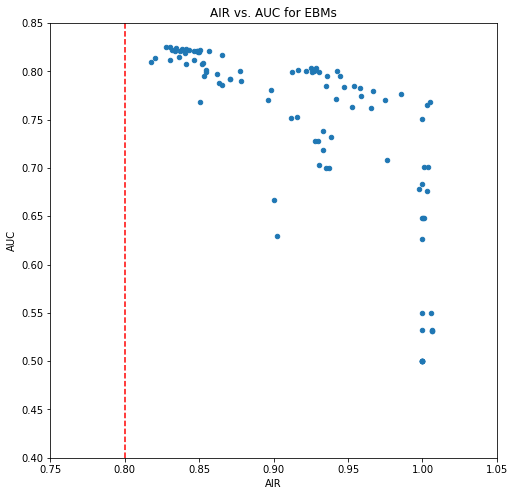

In [213]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ebm_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for EBMs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.75, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

#### Retrain most accurate model above 0.8 AIR

In [162]:
# extract new params dict from ebm_grid_frame
rem_params = ebm_grid_frame.loc[ebm_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict 
rem_x_names = rem_params['features']
del rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name]) 
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Best AUC: 0.8228 above 0.8 AIR (0.8127).
Remediated EBM retrained with AUC: 0.8228.


#### Check that other groups are not adversely impacted

In [170]:
# create a frame with remediated EBM predictions
best_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat']) 
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_ebm_phat2, y_name, 'phat', by=name, level=1, cutoff=0.22, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.126
Adverse impact ratio for Black people vs. White people: 0.813
Adverse impact ratio for Females vs. Males: 0.960


This is the best model, but it uses a cutoff of 0.22.

#### We will use the balanced training data with a 0.17 cutoff

In [229]:
# start local timer
ebm2_tic = time.time()

# new grid search that also considers AIR and fairness
best_ebm3, ebm_grid_frame3 = ebm_grid(balanced_train, best_ebm_phat2, x_names, y_name, gs_params=gs_params, n_models=50, 
                                     early_stopping_rounds=100, seed=SEED, air_reference='white', air_protected='black', 
                                     air_cut=0.17)

# end local timer
ebm2_toc = time.time() - ebm2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 1/50: 0.7720.
---------- ----------
Grid search run 2/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 3/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 1, 'max

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------
Grid search run 26/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ----------
Grid search run 27/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 4, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.25, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ----------
Grid search run 28/50:
Training with parameter

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
EBM training completed in 960.37 s.


In [230]:
ebm_grid_frame3

,max_bins,max_interaction_bins,interactions,outer_bags,inner_bags,learning_rate,validation_size,min_samples_leaf,max_leaves,features,auc,air,early_stopping_rounds,n_jobs,random_state
0,512,16,5,4,0,0.050,0.25,1,3,"[term_360, debt_to_income_ratio_std, loan_to_value_ratio_std, conf...",0.772047,0.620704,100.0,4.0,12345.0
1,128,32,5,8,0,0.001,0.25,2,5,[intro_rate_period_std],0.530308,0.561258,100.0,4.0,12345.0
2,512,16,5,4,0,0.001,0.50,1,3,"[income_std, property_value_std, no_intro_rate_period_std, term_360]",0.721207,0.815710,100.0,4.0,12345.0
3,128,64,5,4,4,0.050,0.50,1,5,"[property_value_std, loan_to_value_ratio_std, debt_to_income_ratio...",0.815204,0.670494,100.0,4.0,12345.0
4,512,64,15,4,0,0.050,0.10,10,3,"[debt_to_income_ratio_missing, intro_rate_period_std, debt_to_inco...",0.819991,0.684844,100.0,4.0,12345.0
5,256,16,15,12,4,0.010,0.10,2,5,"[loan_amount_std, income_std, debt_to_income_ratio_missing, loan_t...",0.817602,0.689938,100.0,4.0,12345.0
6,512,32,15,4,4,0.050,0.25,10,1,"[conforming, property_value_std, income_std, no_intro_rate_period_...",0.777639,0.730389,100.0,4.0,12345.0
7,256,16,15,8,4,0.001,0.50,5,3,"[conforming, debt_to_income_ratio_std, debt_to_income_ratio_missin...",0.810785,0.681952,100.0,4.0,12345.0
8,256,16,10,8,0,0.050,0.50,5,1,"[debt_to_income_ratio_missing, term_360, no_intro_rate_period_std,...",0.780983,0.600817,100.0,4.0,12345.0
9,512,64,5,4,0,0.001,0.25,2,3,[debt_to_income_ratio_std],0.626526,0.902100,100.0,4.0,12345.0


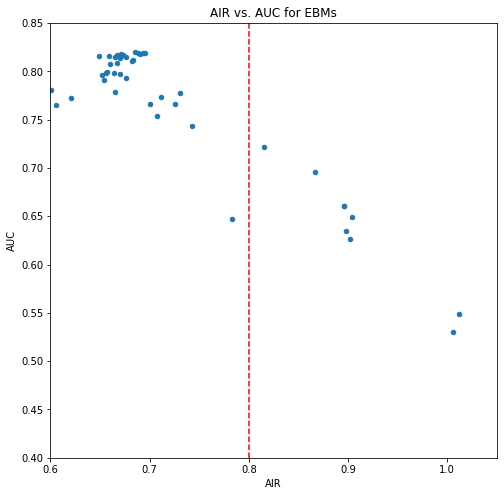

In [260]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ebm_grid_frame3.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for EBMs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.60, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

In [264]:
# extract new params dict from ebm_grid_frame
rem_params3 = ebm_grid_frame3.loc[ebm_grid_frame3['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict 
rem_x_names3 = rem_params3['features']
del rem_params3['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params3['auc'], rem_params3['air']))
del rem_params3['auc']
del rem_params3['air']

# reset some parameters to integers
rem_params3['random_state'] = int(rem_params3['random_state'])
rem_params3['n_jobs'] = int(rem_params3['n_jobs'])


Best AUC: 0.7212 above 0.8 AIR (0.8157).


This approach doesn't perform well because we are forcing the 0.17 cutoff on the model. With a cutoff of 0.22, we saw it achieve a AUC of 0.8228 with an AIR above 0.8 for Black vs White people. Now, with a cutoff of 0.17, it produces a low AUC of 0.7212. The model performed better with the original training set when using a 0.17 cutoff.

### GBM Model

#### We will look at a GBM model

In [249]:
# convert data to h2o frames
htrain = h2o.H2OFrame(train)
hvalid = h2o.H2OFrame(valid)

In [250]:
htrain["high_priced"] = htrain["high_priced"].asfactor()
hvalid["high_priced"] = hvalid["high_priced"].asfactor()

In [251]:
# load saved best model from lecture 1 
best_gbm_model1 = h2o.load_model('best_grid_gbm')

# display model details
best_gbm_model1

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  best_grid_gbm


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,155002.0,0.0,9.0,4.48,1.0,371.0,118.67




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0721415189720421
RMSE: 0.26859173288104404
LogLoss: 0.2382816909972243
Mean Per-Class Error: 0.21397577403396673
AUC: 0.8546995064534598
AUCPR: 0.38509610630118146
Gini: 0.7093990129069196

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20177983589693585: 


,,0,1,Error,Rate
0,0,85733.0,15593.0,0.1539,(15593.0/101326.0)
1,1,4126.0,6801.0,0.3776,(4126.0/10927.0)
2,Total,89859.0,22394.0,0.1757,(19719.0/112253.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.201780,0.408211,198.0
1,max f2,0.120466,0.569460,266.0
2,max f0point5,0.280579,0.386254,135.0
3,max accuracy,0.426367,0.906844,70.0
4,max precision,0.931941,1.000000,0.0
5,max recall,0.004540,1.000000,395.0
6,max specificity,0.931941,1.000000,0.0
7,max absolute_mcc,0.134163,0.357904,255.0
8,max min_per_class_accuracy,0.161060,0.769653,234.0
9,max mean_per_class_accuracy,0.106305,0.786024,277.0



Gains/Lift Table: Avg response rate:  9.73 %, avg score:  9.74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010004,0.423970,7.272511,7.272511,0.707925,0.532936,0.707925,0.532936,0.072756,0.072756,627.251098,627.251098,0.069518
1,2,0.020026,0.372382,4.711880,5.991056,0.458667,0.393393,0.583185,0.463103,0.047222,0.119978,371.187969,499.105626,0.110731
2,3,0.030021,0.338103,4.257524,5.413898,0.414439,0.354612,0.527003,0.426982,0.042555,0.162533,325.752405,441.389806,0.146802
3,4,0.040008,0.314063,3.619833,4.966081,0.352364,0.325696,0.483411,0.401700,0.036149,0.198682,261.983268,396.608080,0.175786
4,5,0.050003,0.299691,3.415175,4.656065,0.332442,0.306071,0.453234,0.382584,0.034136,0.232818,241.517520,365.606547,0.202529
5,6,0.100024,0.255102,3.044392,3.850085,0.296349,0.274058,0.374777,0.328312,0.152283,0.385101,204.439202,285.008520,0.315820
6,7,0.150072,0.226872,2.485048,3.394857,0.241901,0.240200,0.330464,0.298927,0.124371,0.509472,148.504773,239.485663,0.398158
7,8,0.200012,0.200892,2.288792,3.118685,0.222797,0.213902,0.303581,0.277697,0.114304,0.623776,128.879217,211.868536,0.469462
8,9,0.300161,0.148959,1.728919,2.654990,0.168297,0.175957,0.258444,0.243752,0.173149,0.796925,72.891867,165.498983,0.550335
9,10,0.399998,0.086028,1.158657,2.281515,0.112787,0.116057,0.222089,0.211880,0.115677,0.912602,15.865653,128.151469,0.567883




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.07498914941234473
RMSE: 0.27384146766394735
LogLoss: 0.25024806613340816
Mean Per-Class Error: 0.23745707582264086
AUC: 0.82378921353431
AUCPR: 0.293014708515559
Gini: 0.64757842706862

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17230667961946017: 


,,0,1,Error,Rate
0,0,34091.0,9416.0,0.2164,(9416.0/43507.0)
1,1,1445.0,3133.0,0.3156,(1445.0/4578.0)
2,Total,35536.0,12549.0,0.2259,(10861.0/48085.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.172307,0.365855,220.0
1,max f2,0.104995,0.534847,274.0
2,max f0point5,0.232546,0.310608,163.0
3,max accuracy,0.654795,0.905417,17.0
4,max precision,0.866300,1.000000,0.0
5,max recall,0.003646,1.000000,397.0
6,max specificity,0.866300,1.000000,0.0
7,max absolute_mcc,0.104995,0.318731,274.0
8,max min_per_class_accuracy,0.148674,0.746845,239.0
9,max mean_per_class_accuracy,0.089922,0.762543,288.0



Gains/Lift Table: Avg response rate:  9.52 %, avg score:  9.69 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.412372,4.913277,4.913277,0.467775,0.517838,0.467775,0.517838,0.049148,0.049148,391.327728,391.327728,0.043264
1,2,0.020027,0.369611,4.031424,4.471893,0.383817,0.389619,0.425753,0.453662,0.040411,0.089559,303.142442,347.189298,0.076848
2,3,0.030009,0.335571,3.391754,4.112595,0.322917,0.352243,0.391545,0.419926,0.033858,0.123416,239.175359,311.259505,0.103236
3,4,0.040012,0.311718,2.707762,3.761387,0.257796,0.322256,0.358108,0.395508,0.027086,0.150502,170.776170,276.138671,0.122116
4,5,0.050036,0.296688,3.050808,3.619035,0.290456,0.303727,0.344555,0.377121,0.030581,0.181083,205.080767,261.903464,0.144836
5,6,0.100010,0.254087,2.823661,3.221596,0.268831,0.273218,0.306717,0.325202,0.141110,0.322193,182.366115,222.159598,0.245562
6,7,0.150005,0.226607,2.599659,3.014312,0.247504,0.239907,0.286982,0.296775,0.129969,0.452163,159.965870,201.431230,0.333952
7,8,0.200021,0.200766,2.188046,2.807703,0.208316,0.213690,0.267311,0.275999,0.109436,0.561599,118.804615,180.770281,0.399625
8,9,0.300010,0.148257,1.856899,2.490812,0.176789,0.175708,0.237141,0.242573,0.185671,0.747270,85.689907,149.081217,0.494322
9,10,0.400021,0.085584,1.258061,2.182608,0.119775,0.114897,0.207798,0.210653,0.125819,0.873089,25.806053,118.260824,0.522846




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-06-02 12:45:51,3 min 58.648 sec,0.0,0.296424,0.319205,0.500000,0.097343,1.000000,0.902657,0.293508,0.314447,0.500000,0.095206,1.000000,0.904794
1,,2021-06-02 12:45:51,3 min 58.742 sec,1.0,0.292525,0.306887,0.820574,0.297835,4.832668,0.217250,0.289966,0.303269,0.805213,0.261895,4.130015,0.220173
2,,2021-06-02 12:45:51,3 min 58.846 sec,2.0,0.289364,0.297669,0.824992,0.310552,5.368977,0.206471,0.287124,0.294894,0.810491,0.270901,4.436259,0.223625
3,,2021-06-02 12:45:52,3 min 59.009 sec,3.0,0.286809,0.290488,0.827612,0.316673,5.533695,0.213883,0.284854,0.288359,0.813433,0.275922,4.572363,0.219341
4,,2021-06-02 12:45:52,3 min 59.166 sec,4.0,0.284583,0.284399,0.830739,0.324457,5.779129,0.193768,0.282975,0.283002,0.815354,0.279588,4.501498,0.216908
5,,2021-06-02 12:45:52,3 min 59.442 sec,5.0,0.282728,0.279288,0.832910,0.327814,5.765729,0.215451,0.281385,0.278415,0.817566,0.283241,4.467744,0.226432
6,,2021-06-02 12:45:52,3 min 59.668 sec,6.0,0.281057,0.274690,0.834391,0.331205,5.898981,0.216520,0.280037,0.274457,0.818284,0.284119,4.498378,0.219320
7,,2021-06-02 12:45:52,3 min 59.849 sec,7.0,0.279648,0.270802,0.835614,0.334129,5.916031,0.211344,0.278932,0.271146,0.818993,0.285029,4.507325,0.223396
8,,2021-06-02 12:45:53,4 min 0.028 sec,8.0,0.278461,0.267465,0.836878,0.336551,6.085681,0.206427,0.278030,0.268356,0.819481,0.286221,4.696173,0.213788
9,,2021-06-02 12:45:53,4 min 0.166 sec,9.0,0.277483,0.264683,0.837477,0.338411,6.117223,0.208832,0.277304,0.266009,0.819931,0.287130,4.738583,0.222127



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_std,3388.929932,1.000000,0.394752
1,property_value_std,1511.641235,0.446053,0.176080
2,debt_to_income_ratio_std,1328.435547,0.391993,0.154740
3,loan_amount_std,911.447571,0.268948,0.106168
4,income_std,709.055359,0.209227,0.082593
5,intro_rate_period_std,531.960083,0.156970,0.061964
6,no_intro_rate_period_std,88.260742,0.026044,0.010281
7,term_360,70.060158,0.020673,0.008161
8,conforming,38.792511,0.011447,0.004519
9,debt_to_income_ratio_missing,6.383875,0.001884,0.000744


In [252]:
gbm_model_phat = best_gbm_model1.predict(hvalid).as_data_frame()
gbm_model_phat.drop(['predict','p0'], axis = 1, inplace =True)
gbm_model_phat.columns = ['phat']
gbm_model_phat = pd.concat([valid.reset_index(drop=True), gbm_model_phat], axis=1)
gbm_model_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.191695
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.285438
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.020010
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.012104
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.005548


In [271]:
f1_frame = get_max_f1_frame(gbm_model_phat, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best GBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.228349  0.363856
2    0.02  0.264545  0.485786
3    0.03  0.284684  0.542144
4    0.04  0.297967  0.578517
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best GBM F1: 0.3658 achieved at cutoff: 0.17 with accuracy: 0.7727.


In [272]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(gbm_model_phat, y_name, 'phat', by=name, level=1, cutoff=0.21)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       394       699
predicted: 0       270      1829

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        82       134
predicted: 0        66      2968

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      1610      4719
predicted: 0      1555     26641

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1       865      2387
predicted: 0       799     11781

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       695      1692
predicted: 0       545      7100



In [273]:
print('Best GBM AUC: %.4f' % 
      best_gbm_model1.auc(valid=True))

Best GBM AUC: 0.8238


In [274]:
# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female', verbose=False))


Adverse impact ratio for Asian people vs. White people: 1.143
Adverse impact ratio for Black people vs. White people: 0.805
Adverse impact ratio for Females vs. Males: 0.959


This GBM model does well with a cutoff of 0.21.